In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/02/2017 01:04:46 AM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:

import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=128
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]=1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(128,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [13]:
print np.mean(daily_data==0)
daily_data += (daily_data==0)*0.1
print np.mean(daily_data==0)

0.0909115851232
0.0


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            self._session = tf.Session(graph=self.graph)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                error=predictions-float_labels                
                loss2=tf.reduce_sum(tf.abs(error)*self.mask)/tf.reduce_sum(self.mask)
                maeloss=tf.identity(loss2,'mae')
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = maeloss + l2_loss
                self.maeloss=maeloss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [24]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, reader, coord):
        count = 0
        loss = []; l2_loss = [];smape=[]
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa,aaa = model.session.run([model.optimizer, model.loss, model.l2_loss,model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    smape.append(aaa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}, SMAPE: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss),np.mean(smape)))
                        loss = []; l2_loss = [];smape=[]
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        # config.gpu_options.per_process_gpu_memory_fraction = 0.3  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(daily_data,attrib_data,batchsize=batch_size,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [25]:
daily_data.shape

(145063, 550)

In [26]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [ ]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=128, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_mad', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/02/2017 01:10:56 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/02/2017 01:10:56 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)
(145063, 550) (145063, 12)


08/02/2017 01:11:08 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/02/2017 01:11:08 AM INFO: [epoch 0] start net training
08/02/2017 01:11:21 AM INFO: [epoch 0][step 25600] AVG LOSS: 1910.89599609, L2LOSS: 0.0, SMAPE: 1.491989851
08/02/2017 01:11:34 AM INFO: [epoch 0][step 51200] AVG LOSS: 1046.21374512, L2LOSS: 0.0, SMAPE: 1.3850325346
08/02/2017 01:11:47 AM INFO: [epoch 0][step 76800] AVG LOSS: 1800.30004883, L2LOSS: 0.0, SMAPE: 1.36045396328
08/02/2017 01:12:00 AM INFO: [epoch 0][step 102400] AVG LOSS: 2683.29125977, L2LOSS: 0.0, SMAPE: 1.33907544613
08/02/2017 01:12:13 AM INFO: [epoch 0][step 128000] AVG LOSS: 1564.4786377, L2LOSS: 0.0, SMAPE: 1.33248627186
08/02/2017 01:12:26 AM INFO: [epoch 0][step 153600] AVG LOSS: 1092.38598633, L2LOSS: 0.0, SMAPE: 1.33064115047
08/02/2017 01:12:39 AM INFO: [epoch 0][step 179200] AVG LOSS: 2061.45507812, L2LOSS: 0.0, SMAPE: 1.32496440411
08/02/2017 01:12:52 AM INFO: [ep

08/02/2017 01:26:21 AM INFO: [epoch 6][step 256000] AVG LOSS: 687.609069824, L2LOSS: 0.0, SMAPE: 0.533041477203
08/02/2017 01:26:22 AM INFO: [epoch 7] start net training
08/02/2017 01:26:35 AM INFO: [epoch 7][step 25600] AVG LOSS: 1418.73059082, L2LOSS: 0.0, SMAPE: 0.499848902225
08/02/2017 01:26:48 AM INFO: [epoch 7][step 51200] AVG LOSS: 742.411865234, L2LOSS: 0.0, SMAPE: 0.522592067719
08/02/2017 01:27:01 AM INFO: [epoch 7][step 76800] AVG LOSS: 550.415100098, L2LOSS: 0.0, SMAPE: 0.498631387949
08/02/2017 01:27:14 AM INFO: [epoch 7][step 102400] AVG LOSS: 776.757751465, L2LOSS: 0.0, SMAPE: 0.498599767685
08/02/2017 01:27:27 AM INFO: [epoch 7][step 128000] AVG LOSS: 652.53112793, L2LOSS: 0.0, SMAPE: 0.520042181015
08/02/2017 01:27:40 AM INFO: [epoch 7][step 153600] AVG LOSS: 993.574035645, L2LOSS: 0.0, SMAPE: 0.511804819107
08/02/2017 01:27:52 AM INFO: [epoch 7][step 179200] AVG LOSS: 542.452697754, L2LOSS: 0.0, SMAPE: 0.49054184556
08/02/2017 01:28:05 AM INFO: [epoch 7][step 204800]

08/02/2017 01:41:23 AM INFO: [epoch 13][step 256000] AVG LOSS: 523.059570312, L2LOSS: 0.0, SMAPE: 0.473242044449
08/02/2017 01:41:25 AM INFO: [epoch 14] start net training
08/02/2017 01:41:38 AM INFO: [epoch 14][step 25600] AVG LOSS: 1050.71240234, L2LOSS: 0.0, SMAPE: 0.490310549736
08/02/2017 01:41:50 AM INFO: [epoch 14][step 51200] AVG LOSS: 1552.20861816, L2LOSS: 0.0, SMAPE: 0.458107411861
08/02/2017 01:42:03 AM INFO: [epoch 14][step 76800] AVG LOSS: 624.823486328, L2LOSS: 0.0, SMAPE: 0.462779968977
08/02/2017 01:42:16 AM INFO: [epoch 14][step 102400] AVG LOSS: 623.208618164, L2LOSS: 0.0, SMAPE: 0.481002092361
08/02/2017 01:42:28 AM INFO: [epoch 14][step 128000] AVG LOSS: 622.809814453, L2LOSS: 0.0, SMAPE: 0.466970294714
08/02/2017 01:42:41 AM INFO: [epoch 14][step 153600] AVG LOSS: 645.820922852, L2LOSS: 0.0, SMAPE: 0.463792353868
08/02/2017 01:42:54 AM INFO: [epoch 14][step 179200] AVG LOSS: 846.215393066, L2LOSS: 0.0, SMAPE: 0.466580539942
08/02/2017 01:43:06 AM INFO: [epoch 14][

08/02/2017 01:56:18 AM INFO: [epoch 20][step 256000] AVG LOSS: 1767.06542969, L2LOSS: 0.0, SMAPE: 0.461933553219
08/02/2017 01:56:19 AM INFO: [epoch 21] start net training
08/02/2017 01:56:32 AM INFO: [epoch 21][step 25600] AVG LOSS: 1136.99987793, L2LOSS: 0.0, SMAPE: 0.462275773287
08/02/2017 01:56:45 AM INFO: [epoch 21][step 51200] AVG LOSS: 794.692504883, L2LOSS: 0.0, SMAPE: 0.449870914221
08/02/2017 01:56:57 AM INFO: [epoch 21][step 76800] AVG LOSS: 569.245666504, L2LOSS: 0.0, SMAPE: 0.458722531796
08/02/2017 01:57:10 AM INFO: [epoch 21][step 102400] AVG LOSS: 686.88873291, L2LOSS: 0.0, SMAPE: 0.452564686537
08/02/2017 01:57:23 AM INFO: [epoch 21][step 128000] AVG LOSS: 1400.89904785, L2LOSS: 0.0, SMAPE: 0.477451562881
08/02/2017 01:57:35 AM INFO: [epoch 21][step 153600] AVG LOSS: 544.229248047, L2LOSS: 0.0, SMAPE: 0.451247811317
08/02/2017 01:57:48 AM INFO: [epoch 21][step 179200] AVG LOSS: 563.723144531, L2LOSS: 0.0, SMAPE: 0.463386923075
08/02/2017 01:58:01 AM INFO: [epoch 21][s

08/02/2017 02:11:13 AM INFO: [epoch 27][step 256000] AVG LOSS: 461.16104126, L2LOSS: 0.0, SMAPE: 0.451009631157
08/02/2017 02:11:14 AM INFO: [epoch 28] start net training
08/02/2017 02:11:27 AM INFO: [epoch 28][step 25600] AVG LOSS: 506.921722412, L2LOSS: 0.0, SMAPE: 0.451627194881
08/02/2017 02:11:39 AM INFO: [epoch 28][step 51200] AVG LOSS: 1067.2052002, L2LOSS: 0.0, SMAPE: 0.492231965065
08/02/2017 02:11:52 AM INFO: [epoch 28][step 76800] AVG LOSS: 653.442077637, L2LOSS: 0.0, SMAPE: 0.476695984602
08/02/2017 02:12:05 AM INFO: [epoch 28][step 102400] AVG LOSS: 563.924743652, L2LOSS: 0.0, SMAPE: 0.471983879805
08/02/2017 02:12:18 AM INFO: [epoch 28][step 128000] AVG LOSS: 1695.63464355, L2LOSS: 0.0, SMAPE: 0.464712798595
08/02/2017 02:12:30 AM INFO: [epoch 28][step 153600] AVG LOSS: 1116.13208008, L2LOSS: 0.0, SMAPE: 0.468507885933
08/02/2017 02:12:43 AM INFO: [epoch 28][step 179200] AVG LOSS: 448.087493896, L2LOSS: 0.0, SMAPE: 0.469514191151
08/02/2017 02:12:56 AM INFO: [epoch 28][st

08/02/2017 02:26:08 AM INFO: [epoch 34][step 256000] AVG LOSS: 526.839660645, L2LOSS: 0.0, SMAPE: 0.446393102407
08/02/2017 02:26:09 AM INFO: [epoch 35] start net training
08/02/2017 02:26:22 AM INFO: [epoch 35][step 25600] AVG LOSS: 531.767211914, L2LOSS: 0.0, SMAPE: 0.473749577999
08/02/2017 02:26:34 AM INFO: [epoch 35][step 51200] AVG LOSS: 1778.31591797, L2LOSS: 0.0, SMAPE: 0.462401092052
08/02/2017 02:26:47 AM INFO: [epoch 35][step 76800] AVG LOSS: 537.354858398, L2LOSS: 0.0, SMAPE: 0.450037389994
08/02/2017 02:27:00 AM INFO: [epoch 35][step 102400] AVG LOSS: 696.231384277, L2LOSS: 0.0, SMAPE: 0.448926955462
08/02/2017 02:27:12 AM INFO: [epoch 35][step 128000] AVG LOSS: 1521.64550781, L2LOSS: 0.0, SMAPE: 0.447840988636
08/02/2017 02:27:25 AM INFO: [epoch 35][step 153600] AVG LOSS: 1555.80810547, L2LOSS: 0.0, SMAPE: 0.451724141836
08/02/2017 02:27:37 AM INFO: [epoch 35][step 179200] AVG LOSS: 687.634155273, L2LOSS: 0.0, SMAPE: 0.454023003578
08/02/2017 02:27:50 AM INFO: [epoch 35][

08/02/2017 02:41:01 AM INFO: [epoch 41][step 256000] AVG LOSS: 657.848876953, L2LOSS: 0.0, SMAPE: 0.443092763424
08/02/2017 02:41:02 AM INFO: [epoch 42] start net training
08/02/2017 02:41:15 AM INFO: [epoch 42][step 25600] AVG LOSS: 471.073669434, L2LOSS: 0.0, SMAPE: 0.437319844961
08/02/2017 02:41:27 AM INFO: [epoch 42][step 51200] AVG LOSS: 567.295837402, L2LOSS: 0.0, SMAPE: 0.441936254501
08/02/2017 02:41:40 AM INFO: [epoch 42][step 76800] AVG LOSS: 479.726531982, L2LOSS: 0.0, SMAPE: 0.442855745554
08/02/2017 02:41:53 AM INFO: [epoch 42][step 102400] AVG LOSS: 1854.74206543, L2LOSS: 0.0, SMAPE: 0.436980903149
08/02/2017 02:42:05 AM INFO: [epoch 42][step 128000] AVG LOSS: 650.295532227, L2LOSS: 0.0, SMAPE: 0.443221390247
08/02/2017 02:42:18 AM INFO: [epoch 42][step 153600] AVG LOSS: 810.357421875, L2LOSS: 0.0, SMAPE: 0.443632364273
08/02/2017 02:42:30 AM INFO: [epoch 42][step 179200] AVG LOSS: 598.270385742, L2LOSS: 0.0, SMAPE: 0.443378865719
08/02/2017 02:42:43 AM INFO: [epoch 42][

08/02/2017 02:55:52 AM INFO: [epoch 48][step 256000] AVG LOSS: 835.235717773, L2LOSS: 0.0, SMAPE: 0.438512444496
08/02/2017 02:55:54 AM INFO: [epoch 49] start net training
08/02/2017 02:56:06 AM INFO: [epoch 49][step 25600] AVG LOSS: 485.248138428, L2LOSS: 0.0, SMAPE: 0.4342276752
08/02/2017 02:56:19 AM INFO: [epoch 49][step 51200] AVG LOSS: 719.971740723, L2LOSS: 0.0, SMAPE: 0.441508114338
08/02/2017 02:56:31 AM INFO: [epoch 49][step 76800] AVG LOSS: 483.249725342, L2LOSS: 0.0, SMAPE: 0.437360942364
08/02/2017 02:56:43 AM INFO: [epoch 49][step 102400] AVG LOSS: 503.68359375, L2LOSS: 0.0, SMAPE: 0.434164196253
08/02/2017 02:56:56 AM INFO: [epoch 49][step 128000] AVG LOSS: 497.230041504, L2LOSS: 0.0, SMAPE: 0.442681849003
08/02/2017 02:57:08 AM INFO: [epoch 49][step 153600] AVG LOSS: 1340.42504883, L2LOSS: 0.0, SMAPE: 0.449681699276
08/02/2017 02:57:21 AM INFO: [epoch 49][step 179200] AVG LOSS: 498.183227539, L2LOSS: 0.0, SMAPE: 0.438725322485
08/02/2017 02:57:33 AM INFO: [epoch 49][ste

08/02/2017 03:10:46 AM INFO: [epoch 55][step 256000] AVG LOSS: 700.58001709, L2LOSS: 0.0, SMAPE: 0.446298480034
08/02/2017 03:10:48 AM INFO: [epoch 56] start net training
08/02/2017 03:11:00 AM INFO: [epoch 56][step 25600] AVG LOSS: 1487.60644531, L2LOSS: 0.0, SMAPE: 0.435662776232
08/02/2017 03:11:13 AM INFO: [epoch 56][step 51200] AVG LOSS: 1884.88317871, L2LOSS: 0.0, SMAPE: 0.452485591173
08/02/2017 03:11:26 AM INFO: [epoch 56][step 76800] AVG LOSS: 1573.0793457, L2LOSS: 0.0, SMAPE: 0.445813715458
08/02/2017 03:11:38 AM INFO: [epoch 56][step 102400] AVG LOSS: 1158.22009277, L2LOSS: 0.0, SMAPE: 0.44619473815
08/02/2017 03:11:51 AM INFO: [epoch 56][step 128000] AVG LOSS: 732.827270508, L2LOSS: 0.0, SMAPE: 0.440159678459
08/02/2017 03:12:04 AM INFO: [epoch 56][step 153600] AVG LOSS: 501.546295166, L2LOSS: 0.0, SMAPE: 0.436178326607
08/02/2017 03:12:17 AM INFO: [epoch 56][step 179200] AVG LOSS: 2015.2109375, L2LOSS: 0.0, SMAPE: 0.436297774315
08/02/2017 03:12:29 AM INFO: [epoch 56][step

08/02/2017 03:25:42 AM INFO: [epoch 62][step 256000] AVG LOSS: 630.045837402, L2LOSS: 0.0, SMAPE: 0.427216231823
08/02/2017 03:25:43 AM INFO: [epoch 63] start net training
08/02/2017 03:25:56 AM INFO: [epoch 63][step 25600] AVG LOSS: 439.290161133, L2LOSS: 0.0, SMAPE: 0.432338029146
08/02/2017 03:26:09 AM INFO: [epoch 63][step 51200] AVG LOSS: 692.422180176, L2LOSS: 0.0, SMAPE: 0.432943850756
08/02/2017 03:26:22 AM INFO: [epoch 63][step 76800] AVG LOSS: 478.965637207, L2LOSS: 0.0, SMAPE: 0.43278875947
08/02/2017 03:26:34 AM INFO: [epoch 63][step 102400] AVG LOSS: 1241.24169922, L2LOSS: 0.0, SMAPE: 0.435211420059
08/02/2017 03:26:47 AM INFO: [epoch 63][step 128000] AVG LOSS: 1412.4230957, L2LOSS: 0.0, SMAPE: 0.448200762272
08/02/2017 03:26:59 AM INFO: [epoch 63][step 153600] AVG LOSS: 1451.01550293, L2LOSS: 0.0, SMAPE: 0.443089842796
08/02/2017 03:27:12 AM INFO: [epoch 63][step 179200] AVG LOSS: 558.931152344, L2LOSS: 0.0, SMAPE: 0.433632820845
08/02/2017 03:27:24 AM INFO: [epoch 63][st

08/02/2017 03:40:34 AM INFO: [epoch 69][step 256000] AVG LOSS: 1826.95715332, L2LOSS: 0.0, SMAPE: 0.429936379194
08/02/2017 03:40:36 AM INFO: [epoch 70] start net training
08/02/2017 03:40:48 AM INFO: [epoch 70][step 25600] AVG LOSS: 1508.17089844, L2LOSS: 0.0, SMAPE: 0.432697981596
08/02/2017 03:41:01 AM INFO: [epoch 70][step 51200] AVG LOSS: 612.474365234, L2LOSS: 0.0, SMAPE: 0.437925636768
08/02/2017 03:41:14 AM INFO: [epoch 70][step 76800] AVG LOSS: 614.242492676, L2LOSS: 0.0, SMAPE: 0.431836396456
08/02/2017 03:41:26 AM INFO: [epoch 70][step 102400] AVG LOSS: 472.882354736, L2LOSS: 0.0, SMAPE: 0.431524306536
08/02/2017 03:41:39 AM INFO: [epoch 70][step 128000] AVG LOSS: 1479.06652832, L2LOSS: 0.0, SMAPE: 0.43274590373
08/02/2017 03:41:52 AM INFO: [epoch 70][step 153600] AVG LOSS: 499.96270752, L2LOSS: 0.0, SMAPE: 0.440925866365
08/02/2017 03:42:05 AM INFO: [epoch 70][step 179200] AVG LOSS: 1748.5123291, L2LOSS: 0.0, SMAPE: 0.43134906888
08/02/2017 03:42:17 AM INFO: [epoch 70][step

08/02/2017 03:55:30 AM INFO: [epoch 76][step 256000] AVG LOSS: 824.473144531, L2LOSS: 0.0, SMAPE: 0.430878549814
08/02/2017 03:55:31 AM INFO: [epoch 77] start net training
08/02/2017 03:55:44 AM INFO: [epoch 77][step 25600] AVG LOSS: 1006.20001221, L2LOSS: 0.0, SMAPE: 0.435537189245
08/02/2017 03:55:56 AM INFO: [epoch 77][step 51200] AVG LOSS: 472.970397949, L2LOSS: 0.0, SMAPE: 0.431919664145
08/02/2017 03:56:09 AM INFO: [epoch 77][step 76800] AVG LOSS: 1803.60205078, L2LOSS: 0.0, SMAPE: 0.427181482315
08/02/2017 03:56:22 AM INFO: [epoch 77][step 102400] AVG LOSS: 1370.00036621, L2LOSS: 0.0, SMAPE: 0.433070331812
08/02/2017 03:56:34 AM INFO: [epoch 77][step 128000] AVG LOSS: 849.542663574, L2LOSS: 0.0, SMAPE: 0.433084458113
08/02/2017 03:56:47 AM INFO: [epoch 77][step 153600] AVG LOSS: 504.237548828, L2LOSS: 0.0, SMAPE: 0.435926318169
08/02/2017 03:57:00 AM INFO: [epoch 77][step 179200] AVG LOSS: 743.288269043, L2LOSS: 0.0, SMAPE: 0.434544801712
08/02/2017 03:57:13 AM INFO: [epoch 77][

08/02/2017 04:10:24 AM INFO: [epoch 83][step 256000] AVG LOSS: 673.639831543, L2LOSS: 0.0, SMAPE: 0.430924504995
08/02/2017 04:10:26 AM INFO: [epoch 84] start net training
08/02/2017 04:10:38 AM INFO: [epoch 84][step 25600] AVG LOSS: 534.92364502, L2LOSS: 0.0, SMAPE: 0.425853222609
08/02/2017 04:10:51 AM INFO: [epoch 84][step 51200] AVG LOSS: 1180.88415527, L2LOSS: 0.0, SMAPE: 0.42697006464
08/02/2017 04:11:04 AM INFO: [epoch 84][step 76800] AVG LOSS: 1236.35205078, L2LOSS: 0.0, SMAPE: 0.430173873901
08/02/2017 04:11:16 AM INFO: [epoch 84][step 102400] AVG LOSS: 696.210876465, L2LOSS: 0.0, SMAPE: 0.432470411062
08/02/2017 04:11:30 AM INFO: [epoch 84][step 128000] AVG LOSS: 626.612243652, L2LOSS: 0.0, SMAPE: 0.426871180534
08/02/2017 04:11:42 AM INFO: [epoch 84][step 153600] AVG LOSS: 608.254333496, L2LOSS: 0.0, SMAPE: 0.426660001278
08/02/2017 04:11:55 AM INFO: [epoch 84][step 179200] AVG LOSS: 680.467590332, L2LOSS: 0.0, SMAPE: 0.435932010412
08/02/2017 04:12:08 AM INFO: [epoch 84][st

08/02/2017 04:25:19 AM INFO: [epoch 90][step 256000] AVG LOSS: 1442.11608887, L2LOSS: 0.0, SMAPE: 0.430910199881
08/02/2017 04:25:20 AM INFO: [epoch 91] start net training
08/02/2017 04:25:33 AM INFO: [epoch 91][step 25600] AVG LOSS: 1340.08349609, L2LOSS: 0.0, SMAPE: 0.430355161428
08/02/2017 04:25:46 AM INFO: [epoch 91][step 51200] AVG LOSS: 432.385559082, L2LOSS: 0.0, SMAPE: 0.422622591257
08/02/2017 04:25:58 AM INFO: [epoch 91][step 76800] AVG LOSS: 693.893310547, L2LOSS: 0.0, SMAPE: 0.428907394409
08/02/2017 04:26:11 AM INFO: [epoch 91][step 102400] AVG LOSS: 630.067565918, L2LOSS: 0.0, SMAPE: 0.430453538895
08/02/2017 04:26:24 AM INFO: [epoch 91][step 128000] AVG LOSS: 671.874511719, L2LOSS: 0.0, SMAPE: 0.432504832745
08/02/2017 04:26:37 AM INFO: [epoch 91][step 153600] AVG LOSS: 626.748474121, L2LOSS: 0.0, SMAPE: 0.428192526102
08/02/2017 04:26:49 AM INFO: [epoch 91][step 179200] AVG LOSS: 794.890380859, L2LOSS: 0.0, SMAPE: 0.426400274038
08/02/2017 04:27:02 AM INFO: [epoch 91][

08/02/2017 04:40:16 AM INFO: [epoch 97][step 256000] AVG LOSS: 461.190460205, L2LOSS: 0.0, SMAPE: 0.420111387968
08/02/2017 04:40:17 AM INFO: [epoch 98] start net training
08/02/2017 04:40:30 AM INFO: [epoch 98][step 25600] AVG LOSS: 446.47833252, L2LOSS: 0.0, SMAPE: 0.422209560871
08/02/2017 04:40:43 AM INFO: [epoch 98][step 51200] AVG LOSS: 542.779846191, L2LOSS: 0.0, SMAPE: 0.422594606876
08/02/2017 04:40:55 AM INFO: [epoch 98][step 76800] AVG LOSS: 652.548034668, L2LOSS: 0.0, SMAPE: 0.434335589409
08/02/2017 04:41:08 AM INFO: [epoch 98][step 102400] AVG LOSS: 573.587280273, L2LOSS: 0.0, SMAPE: 0.432056427002
08/02/2017 04:41:21 AM INFO: [epoch 98][step 128000] AVG LOSS: 931.826538086, L2LOSS: 0.0, SMAPE: 0.427822202444
08/02/2017 04:41:34 AM INFO: [epoch 98][step 153600] AVG LOSS: 1590.60559082, L2LOSS: 0.0, SMAPE: 0.424776077271
08/02/2017 04:41:47 AM INFO: [epoch 98][step 179200] AVG LOSS: 654.01348877, L2LOSS: 0.0, SMAPE: 0.426905542612
08/02/2017 04:42:00 AM INFO: [epoch 98][st

08/02/2017 04:54:57 AM INFO: [epoch 104][step 230400] AVG LOSS: 721.484375, L2LOSS: 0.0, SMAPE: 0.425323039293
08/02/2017 04:55:10 AM INFO: [epoch 104][step 256000] AVG LOSS: 942.692810059, L2LOSS: 0.0, SMAPE: 0.42666298151
08/02/2017 04:55:11 AM INFO: [epoch 105] start net training
08/02/2017 04:55:24 AM INFO: [epoch 105][step 25600] AVG LOSS: 1565.46862793, L2LOSS: 0.0, SMAPE: 0.422194987535
08/02/2017 04:55:37 AM INFO: [epoch 105][step 51200] AVG LOSS: 1255.38598633, L2LOSS: 0.0, SMAPE: 0.431409239769
08/02/2017 04:55:49 AM INFO: [epoch 105][step 76800] AVG LOSS: 427.611053467, L2LOSS: 0.0, SMAPE: 0.421087801456
08/02/2017 04:56:02 AM INFO: [epoch 105][step 102400] AVG LOSS: 937.754272461, L2LOSS: 0.0, SMAPE: 0.420776247978
08/02/2017 04:56:14 AM INFO: [epoch 105][step 128000] AVG LOSS: 565.009155273, L2LOSS: 0.0, SMAPE: 0.41801956296
08/02/2017 04:56:27 AM INFO: [epoch 105][step 153600] AVG LOSS: 762.718261719, L2LOSS: 0.0, SMAPE: 0.430055081844
08/02/2017 04:56:39 AM INFO: [epoch 

08/02/2017 05:09:38 AM INFO: [epoch 111][step 204800] AVG LOSS: 1062.80737305, L2LOSS: 0.0, SMAPE: 0.430581241846
08/02/2017 05:09:50 AM INFO: [epoch 111][step 230400] AVG LOSS: 2326.79174805, L2LOSS: 0.0, SMAPE: 0.426282167435
08/02/2017 05:10:03 AM INFO: [epoch 111][step 256000] AVG LOSS: 675.251220703, L2LOSS: 0.0, SMAPE: 0.427651047707
08/02/2017 05:10:04 AM INFO: [epoch 112] start net training
08/02/2017 05:10:17 AM INFO: [epoch 112][step 25600] AVG LOSS: 472.775970459, L2LOSS: 0.0, SMAPE: 0.4189260602
08/02/2017 05:10:29 AM INFO: [epoch 112][step 51200] AVG LOSS: 2591.35400391, L2LOSS: 0.0, SMAPE: 0.425415128469
08/02/2017 05:10:42 AM INFO: [epoch 112][step 76800] AVG LOSS: 1459.89916992, L2LOSS: 0.0, SMAPE: 0.419285684824
08/02/2017 05:10:55 AM INFO: [epoch 112][step 102400] AVG LOSS: 1343.20751953, L2LOSS: 0.0, SMAPE: 0.428712278605
08/02/2017 05:11:07 AM INFO: [epoch 112][step 128000] AVG LOSS: 537.361694336, L2LOSS: 0.0, SMAPE: 0.431592553854
08/02/2017 05:11:20 AM INFO: [epo

08/02/2017 05:24:21 AM INFO: [epoch 118][step 179200] AVG LOSS: 1180.56201172, L2LOSS: 0.0, SMAPE: 0.431903660297
08/02/2017 05:24:34 AM INFO: [epoch 118][step 204800] AVG LOSS: 475.298797607, L2LOSS: 0.0, SMAPE: 0.422449618578
08/02/2017 05:24:47 AM INFO: [epoch 118][step 230400] AVG LOSS: 1105.13659668, L2LOSS: 0.0, SMAPE: 0.421098798513
08/02/2017 05:24:59 AM INFO: [epoch 118][step 256000] AVG LOSS: 677.616638184, L2LOSS: 0.0, SMAPE: 0.425445556641
08/02/2017 05:25:01 AM INFO: [epoch 119] start net training
08/02/2017 05:25:13 AM INFO: [epoch 119][step 25600] AVG LOSS: 735.636535645, L2LOSS: 0.0, SMAPE: 0.422559589148
08/02/2017 05:25:26 AM INFO: [epoch 119][step 51200] AVG LOSS: 578.061096191, L2LOSS: 0.0, SMAPE: 0.427752196789
08/02/2017 05:25:39 AM INFO: [epoch 119][step 76800] AVG LOSS: 535.659423828, L2LOSS: 0.0, SMAPE: 0.423665821552
08/02/2017 05:25:51 AM INFO: [epoch 119][step 102400] AVG LOSS: 827.110839844, L2LOSS: 0.0, SMAPE: 0.4256965518
08/02/2017 05:26:04 AM INFO: [epo

08/02/2017 05:39:03 AM INFO: [epoch 125][step 153600] AVG LOSS: 446.886413574, L2LOSS: 0.0, SMAPE: 0.426621556282
08/02/2017 05:39:16 AM INFO: [epoch 125][step 179200] AVG LOSS: 775.68145752, L2LOSS: 0.0, SMAPE: 0.427037805319
08/02/2017 05:39:29 AM INFO: [epoch 125][step 204800] AVG LOSS: 579.757385254, L2LOSS: 0.0, SMAPE: 0.425978541374
08/02/2017 05:39:41 AM INFO: [epoch 125][step 230400] AVG LOSS: 543.937011719, L2LOSS: 0.0, SMAPE: 0.426498174667
08/02/2017 05:39:54 AM INFO: [epoch 125][step 256000] AVG LOSS: 1575.71862793, L2LOSS: 0.0, SMAPE: 0.438842207193
08/02/2017 05:39:55 AM INFO: [epoch 126] start net training
08/02/2017 05:40:08 AM INFO: [epoch 126][step 25600] AVG LOSS: 1747.47937012, L2LOSS: 0.0, SMAPE: 0.428104817867
08/02/2017 05:40:21 AM INFO: [epoch 126][step 51200] AVG LOSS: 942.90826416, L2LOSS: 0.0, SMAPE: 0.41741669178
08/02/2017 05:40:34 AM INFO: [epoch 126][step 76800] AVG LOSS: 565.843444824, L2LOSS: 0.0, SMAPE: 0.440069198608
08/02/2017 05:40:47 AM INFO: [epoc

08/02/2017 05:53:46 AM INFO: [epoch 132][step 128000] AVG LOSS: 588.879943848, L2LOSS: 0.0, SMAPE: 0.430915862322
08/02/2017 05:53:59 AM INFO: [epoch 132][step 153600] AVG LOSS: 1547.43469238, L2LOSS: 0.0, SMAPE: 0.420693278313
08/02/2017 05:54:11 AM INFO: [epoch 132][step 179200] AVG LOSS: 516.811035156, L2LOSS: 0.0, SMAPE: 0.418310940266
08/02/2017 05:54:24 AM INFO: [epoch 132][step 204800] AVG LOSS: 810.066955566, L2LOSS: 0.0, SMAPE: 0.420875281096
08/02/2017 05:54:37 AM INFO: [epoch 132][step 230400] AVG LOSS: 904.854309082, L2LOSS: 0.0, SMAPE: 0.419392168522
08/02/2017 05:54:50 AM INFO: [epoch 132][step 256000] AVG LOSS: 1434.99755859, L2LOSS: 0.0, SMAPE: 0.419493377209
08/02/2017 05:54:51 AM INFO: [epoch 133] start net training
08/02/2017 05:55:04 AM INFO: [epoch 133][step 25600] AVG LOSS: 766.486694336, L2LOSS: 0.0, SMAPE: 0.428921312094
08/02/2017 05:55:16 AM INFO: [epoch 133][step 51200] AVG LOSS: 475.201019287, L2LOSS: 0.0, SMAPE: 0.423895806074
08/02/2017 05:55:29 AM INFO: [

08/02/2017 06:08:30 AM INFO: [epoch 139][step 102400] AVG LOSS: 797.282409668, L2LOSS: 0.0, SMAPE: 0.428508728743
08/02/2017 06:08:43 AM INFO: [epoch 139][step 128000] AVG LOSS: 522.443847656, L2LOSS: 0.0, SMAPE: 0.421550184488
08/02/2017 06:08:55 AM INFO: [epoch 139][step 153600] AVG LOSS: 2926.44848633, L2LOSS: 0.0, SMAPE: 0.419206619263
08/02/2017 06:09:08 AM INFO: [epoch 139][step 179200] AVG LOSS: 684.084716797, L2LOSS: 0.0, SMAPE: 0.421677201986
08/02/2017 06:09:21 AM INFO: [epoch 139][step 204800] AVG LOSS: 425.117614746, L2LOSS: 0.0, SMAPE: 0.413795590401
08/02/2017 06:09:34 AM INFO: [epoch 139][step 230400] AVG LOSS: 1719.95947266, L2LOSS: 0.0, SMAPE: 0.420677632093
08/02/2017 06:09:47 AM INFO: [epoch 139][step 256000] AVG LOSS: 614.153381348, L2LOSS: 0.0, SMAPE: 0.425959050655
08/02/2017 06:09:48 AM INFO: [epoch 140] start net training
08/02/2017 06:10:01 AM INFO: [epoch 140][step 25600] AVG LOSS: 655.574951172, L2LOSS: 0.0, SMAPE: 0.424294829369
08/02/2017 06:10:13 AM INFO: 

# prediction

In [28]:
sess=tf.Session()

In [29]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_mad/model_0-0.meta')

In [30]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_mad/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_mad/model_0-0


08/02/2017 01:59:09 PM INFO: Restoring parameters from tmp_pred60_lstm_mad/model_0-0


In [31]:
graph = tf.get_default_graph()

In [32]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [33]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(1000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [34]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((1000, 128), (1000, 12), (1000, 60), (1000, 60))

In [35]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [36]:
sess.run(loss,feed_dict=feed_dict)

0.40808728

In [37]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(1000, 60)


In [38]:
a.max(),a.min()

(22114.453, 0.066299438)

In [39]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
22845.6


0.40793532

In [40]:
MASK.sum()

56003.0

In [41]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

513.993 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.513993


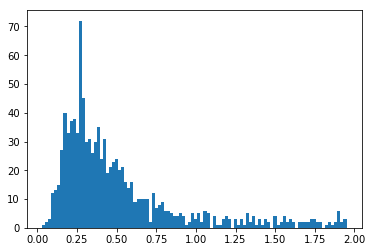

In [42]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

112.0 153.522 0.278354


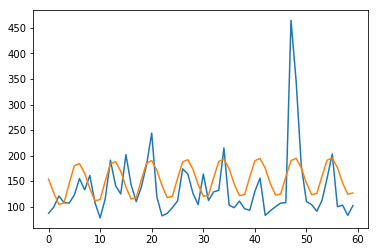

In [45]:
i=880
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [46]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [47]:
daily_test=daily_data[:,-128:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [48]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [49]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

0.035479297500626165

In [50]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [51]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [52]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  20.200001
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.799999
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   5.300000
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.000000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...   9.400000

In [53]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [54]:
keys_dict=keys["Id"].to_dict()

In [55]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [56]:
submission.isnull().sum().sum()

0L

In [57]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  20.200001  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.799999  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   5.300000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.000000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...   9.400000  75bae1fb2637

In [58]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_mad.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")